In [138]:
import numpy as np
import sys
sys.path.append("..")
from cryoem.angle_alignment import training_angle_alignment
from cryoem.conversions import quaternion2euler, d_q, euler2quaternion
import h5py
import os
import tensorflow as tf
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)

In [139]:
PROTEIN="5j0n"
ROOT_DIR = ".."
NUM_PROJECTIONS = 5000

In [140]:
# location of *.h5 files
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [141]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

In [142]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

In [143]:
data = np.load(f"1-phase1/data/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data["arr_0"], data["arr_1"], data["arr_2"]

In [144]:
tick_size=15
label_size=15

---

In [192]:
data = np.load("1-phase1/data/5j0n/angle_recovery_limited3.14_estimated_50k_testset.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)

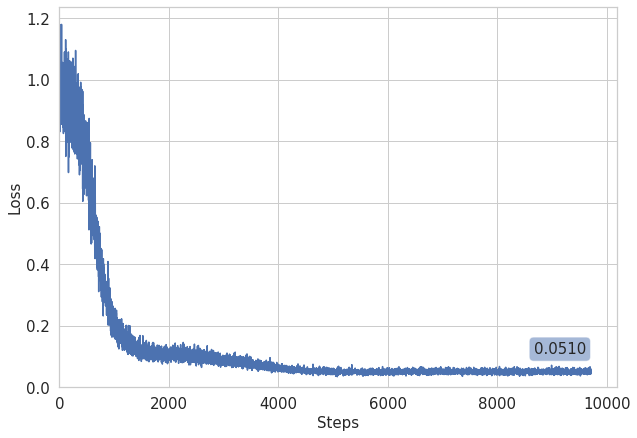

In [53]:
losses_plot = losses[losses>1e-5]

fig, ax = plt.subplots(figsize=(10,7))
plt.plot(losses_plot) # np.arange(0., 0.474*len(losses[losses>1e-5]), 0.474),
plt.xlabel("Steps", fontsize=tick_size)
plt.ylabel("Loss", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_xlim(0)
ax.set_ylim(0)

props = dict(boxstyle='round', facecolor='b', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.85, 0.12, f"{np.mean(losses_plot[-10:]):.4f}", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

plt.show()

In [36]:
losses_plot[-1]

0.057146993442582596

In [193]:
rerun=False

In [194]:
if rerun:
    m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                            steps=300, 
                                                            batch_size=256, 
                                                            optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                            angles_true=angles_true[test_idx], 
                                                            angles_predicted=angles_predicted)
    m = m
    trajectory_first = trajectory[0]
    loss_first = losses[0]
    trajectory_last = trajectory[-1]
    loss_last = losses[-1]
else:
    m = [1.0, 1.0, 1.0, -1.0]
    trajectory_first = [3.13879209, 5.8288423 , 4.72386168, 5.04477556, 6.2322907 , 2.73919099]
    loss_first = 2.125392521810764
    trajectory_last = [-16.20468257,  -6.31558929,  -0.22906401,  16.38595998, -4.98906294, -38.38066144]
    loss_last = 0.15939222928360752

Text(0.62, 0.24, '$E$ = 2.1254 rad')

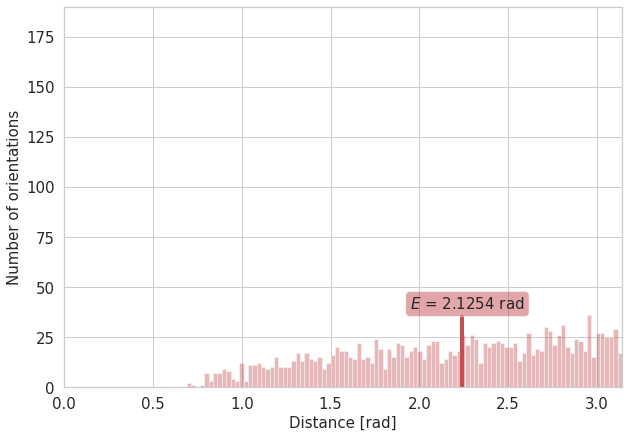

In [195]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
q_predicted_rot = update_quaternion(m, [tf.Variable(trajectory_first)], q_predicted)
d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 190)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=100, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.62, 0.24, f"$E$ = {loss_first:.4f} rad", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

Text(0.01, 0.99, '$E$ = 0.1594 rad')

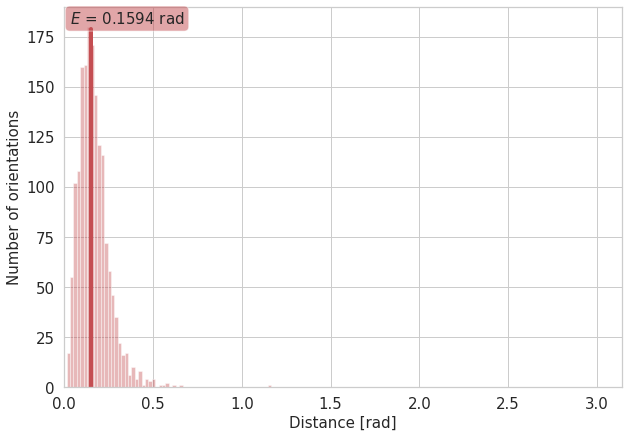

In [196]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
q_predicted_rot = update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted)
d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 190)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=60, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.01, 0.99, f"$E$ = {loss_last:.4f} rad", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

---

In [197]:
data = np.load("/mnt/scratch/students/angle_recovery_noisy16_limited3.14_estimated_50k.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)

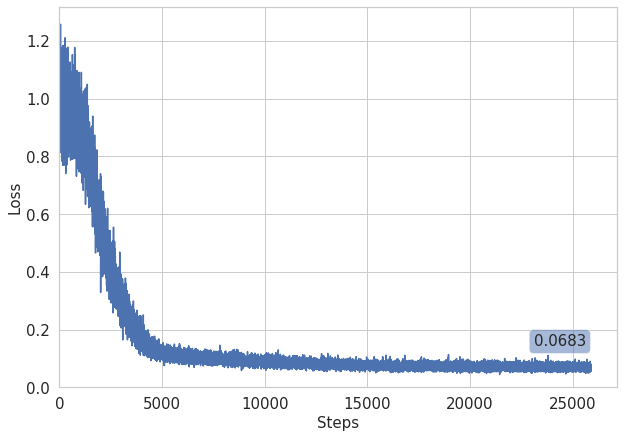

In [50]:
losses_plot = losses[losses>1e-5]

fig, ax = plt.subplots(figsize=(10,7))
plt.plot(losses_plot) # np.arange(0., 0.474*len(losses[losses>1e-5]), 0.474),
plt.xlabel("Steps", fontsize=tick_size)
plt.ylabel("Loss", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_xlim(0)
ax.set_ylim(0)

props = dict(boxstyle='round', facecolor='b', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.85, 0.14, f"{np.mean(losses_plot[-10:]):.4f}", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

plt.show()

In [198]:
rerun=False

In [199]:
if rerun:
    m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                            steps=300, 
                                                            batch_size=256, 
                                                            optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                            angles_true=angles_true[test_idx], 
                                                            angles_predicted=np.array(angles_predicted)[test_idx])
    m = m
    trajectory_first = trajectory[0]
    loss_first = losses[0]
    trajectory_last = trajectory[-1]
    loss_last = losses[-1]
else:
    m = [1.0, 1.0, 1.0, -1.0]
    trajectory_first = [1.55300104, 2.81036984, 5.2178074 , 0.18295697, 2.11496371, 3.09141405]
    loss_first = 2.661634550544549
    trajectory_last = [ 8.34225157, 20.60956391, 19.13156328, 11.4381577 ,  2.8817712 , 16.02597525]
    loss_last = 0.418361192772094

In [200]:
m, trajectory_first, loss_first, trajectory_last, loss_last

([1.0, 1.0, 1.0, -1.0],
 [1.55300104, 2.81036984, 5.2178074, 0.18295697, 2.11496371, 3.09141405],
 2.661634550544549,
 [8.34225157, 20.60956391, 19.13156328, 11.4381577, 2.8817712, 16.02597525],
 0.418361192772094)

Text(0.77, 0.72, '$E$ = 2.6616 rad')

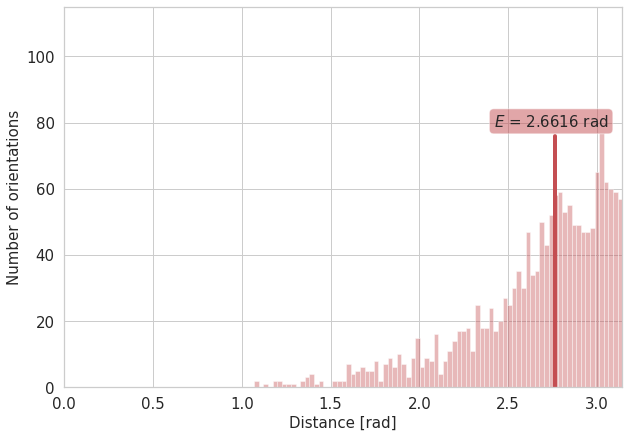

In [201]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
q_predicted_rot = update_quaternion(m, [tf.Variable(trajectory_first)], q_predicted[test_idx])
d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 115)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=80, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.77, 0.72, f"$E$ = {loss_first:.4f} rad", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

Text(0.03, 0.95, '$E$ = 0.4184 rad')

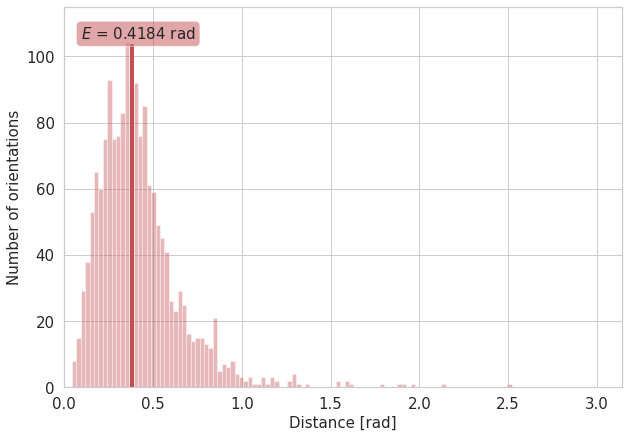

In [202]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
q_predicted_rot = update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted[test_idx])
d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 115)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=100, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.03, 0.95, f"$E$ = {loss_last:.4f} rad", transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)

---

# Noisy d_P

In [145]:
import pandas as pd

In [146]:
df0_train = pd.read_csv("/mnt/scratch/students/run-noisy_var0_train-tag-epoch_loss.csv")
df0_train["noise_variance"] = df0_train.apply(lambda x: 0, axis=1)
df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)

df0_val = pd.read_csv("/mnt/scratch/students/run-noisy_var0_validation-tag-epoch_loss.csv")
df0_val["noise_variance"] = df0_val.apply(lambda x: 0, axis=1)
df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)

df5_train = pd.read_csv("/mnt/scratch/students/run-noisy_var5_train-tag-epoch_loss.csv")
df5_train["noise_variance"] = df5_train.apply(lambda x: 5, axis=1)
df5_train["dataset"] = df5_train.apply(lambda x: "train", axis=1)

df5_val = pd.read_csv("/mnt/scratch/students/run-noisy_var5_validation-tag-epoch_loss.csv")
df5_val["noise_variance"] = df5_val.apply(lambda x: 5, axis=1)
df5_val["dataset"] = df5_val.apply(lambda x: "validation", axis=1)

df10_train = pd.read_csv("/mnt/scratch/students/run-noisy_var10_train-tag-epoch_loss.csv")
df10_train["noise_variance"] = df10_train.apply(lambda x: 10, axis=1)
df10_train["dataset"] = df10_train.apply(lambda x: "train", axis=1)

df10_val = pd.read_csv("/mnt/scratch/students/run-noisy_var10_validation-tag-epoch_loss.csv")
df10_val["noise_variance"] = df10_val.apply(lambda x: 10, axis=1)
df10_val["dataset"] = df10_val.apply(lambda x: "validation", axis=1)

df14_train = pd.read_csv("/mnt/scratch/students/run-noisy_var14_train-tag-epoch_loss.csv")
df14_train["noise_variance"] = df14_train.apply(lambda x: 15, axis=1)
df14_train["dataset"] = df14_train.apply(lambda x: "train", axis=1)

df14_val = pd.read_csv("/mnt/scratch/students/run-noisy_var14_validation-tag-epoch_loss.csv")
df14_val["noise_variance"] = df14_val.apply(lambda x: 15, axis=1)
df14_val["dataset"] = df14_val.apply(lambda x: "validation", axis=1)

df20_train = pd.read_csv("/mnt/scratch/students/run-noisy_var20_train-tag-epoch_loss.csv")
df20_train["noise_variance"] = df20_train.apply(lambda x: 20, axis=1)
df20_train["dataset"] = df20_train.apply(lambda x: "train", axis=1)

df20_val = pd.read_csv("/mnt/scratch/students/run-noisy_var20_validation-tag-epoch_loss.csv")
df20_val["noise_variance"] = df20_val.apply(lambda x: 20, axis=1)
df20_val["dataset"] = df20_val.apply(lambda x: "validation", axis=1)

df25_train = pd.read_csv("/mnt/scratch/students/run-noisy_var25_train-tag-epoch_loss.csv")
df25_train["noise_variance"] = df25_train.apply(lambda x: 25, axis=1)
df25_train["dataset"] = df25_train.apply(lambda x: "train", axis=1)

df25_val = pd.read_csv("/mnt/scratch/students/run-noisy_var25_validation-tag-epoch_loss.csv")
df25_val["noise_variance"] = df25_val.apply(lambda x: 25, axis=1)
df25_val["dataset"] = df25_val.apply(lambda x: "validation", axis=1)

In [147]:
df0_train.tail()

,Wall time,Step,Value,noise_variance,dataset
145,1.591844e+09,145,0.148059,0,train
146,1.591845e+09,146,0.148482,0,train
147,1.591845e+09,147,0.148325,0,train
148,1.591845e+09,148,0.147807,0,train
149,1.591845e+09,149,0.147884,0,train


In [148]:
df = pd.concat([eval(f"df{i}_{d}") for i in [0, 5, 10, 14, 20, 25] for d in ["train", "val"]])

In [149]:
df.head()

,Wall time,Step,Value,noise_variance,dataset
0,1.591812e+09,0,1.579067,0,train
1,1.591812e+09,1,0.406497,0,train
2,1.591812e+09,2,0.306583,0,train
3,1.591813e+09,3,0.269863,0,train
4,1.591813e+09,4,0.248328,0,train


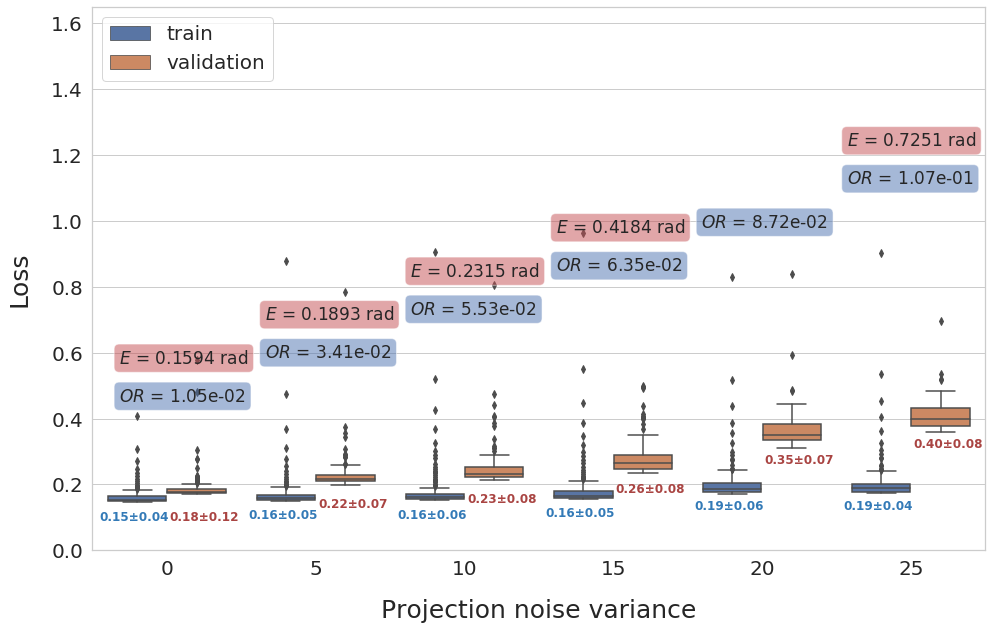

In [152]:
fig, ax = plt.subplots(figsize=(16,10))

mapping = {0:0, 1:5, 2:10, 3:15, 4:20, 5:25}

box_plot = sns.boxplot(x="noise_variance", y="Value", hue="dataset", data=df, ax=ax)
box_plot.tick_params(labelsize=20)
ax.set_xlabel("Projection noise variance", fontsize=25, labelpad=20);
ax.set_ylabel("Loss", fontsize=25, labelpad=20);
ax.set_ylim(0)
ax.legend(loc=2, fontsize=20)

medians_na = df[df.dataset=='train'].groupby(['noise_variance'])['Value'].median()#.sort_values(ascending=False)
stds_na = df[df.dataset=='train'].groupby(['noise_variance'])['Value'].std()
vertical_offset_na = df[df.dataset=='train']['noise_variance'].median() * 0.005 # offset from median for display
horizontal_offset_na = 0.25

medians = df[df.dataset=='validation'].groupby(['noise_variance'])['Value'].median()#.sort_values(ascending=False)
stds = df[df.dataset=='validation'].groupby(['noise_variance'])['Value'].std()
vertical_offset = df[df.dataset=='validation']['noise_variance'].median() * 0.007 # offset from median for display
horizontal_offset = 0.22

props_red = dict(boxstyle='round', facecolor='r', alpha=0.5)
props_blue = dict(boxstyle='round', facecolor='b', alpha=0.5)

Es = [0.1594, 0.1893, 0.2315, 0.4184, 0.0, 0.7251]
ARs = [1.05e-02, 3.41e-02, 5.53e-02, 6.35e-02, 8.72e-02, 1.07e-01]

for xtick in box_plot.get_xticks():
    box_plot.text(xtick+horizontal_offset_na, 
                  medians[mapping[xtick]] - vertical_offset, 
                  f"{medians[mapping[xtick]]:.2f}±{stds_na[mapping[xtick]]:.2f}", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=12, color='#A94442')
    #print(xtick)
    
    box_plot.text(0.03+xtick*0.163, 0.3+xtick*0.08, f"$OR$ = {ARs[xtick]:.2e}", transform=ax.transAxes, fontsize=17, verticalalignment='top', bbox=props_blue)
    if xtick not in [4]:
        box_plot.text(0.03+xtick*0.163, 0.37+xtick*0.08, f"$E$ = {Es[xtick]:.4f} rad", transform=ax.transAxes, fontsize=17, verticalalignment='top', bbox=props_red)
    

for xtick in box_plot.get_xticks():
    box_plot.text(xtick-horizontal_offset, 
                  medians_na[mapping[xtick]] - vertical_offset_na, 
                  f"{medians_na[mapping[xtick]]:.2f}±{stds[mapping[xtick]]:.2f}", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=12, color='#337AB7')
    

In [92]:
df0_train.head()

,Wall time,Step,Value,translation,dataset
0,1.591812e+09,0,1.579067,0,train
1,1.591812e+09,1,0.406497,0,train
2,1.591812e+09,2,0.306583,0,train
3,1.591813e+09,3,0.269863,0,train
4,1.591813e+09,4,0.248328,0,train


In [96]:
df0_train = pd.read_csv("/mnt/scratch/students/run-noisy_var0_train-tag-epoch_loss.csv")
df0_train["translation"] = df0_train.apply(lambda x: 0, axis=1)
df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)
#df0_train = df0_train[df0_train.Step<100]

df0_val = pd.read_csv("/mnt/scratch/students/run-noisy_var0_validation-tag-epoch_loss.csv")
df0_val["translation"] = df0_val.apply(lambda x: 0, axis=1)
df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)
#df0_val = df0_val[df0_val.Step<100]

df5_train = pd.read_csv("/mnt/scratch/students/run-translation5_train-tag-epoch_loss.csv")
df5_train["translation"] = df5_train.apply(lambda x: 5, axis=1)
df5_train["dataset"] = df5_train.apply(lambda x: "train", axis=1)

df5_val = pd.read_csv("/mnt/scratch/students/run-translation5_validation-tag-epoch_loss.csv")
df5_val["translation"] = df5_val.apply(lambda x: 5, axis=1)
df5_val["dataset"] = df5_val.apply(lambda x: "validation", axis=1)

df10_train = pd.read_csv("/mnt/scratch/students/run-translation10_train-tag-epoch_loss.csv")
df10_train["translation"] = df10_train.apply(lambda x: 10, axis=1)
df10_train["dataset"] = df10_train.apply(lambda x: "train", axis=1)

df10_val = pd.read_csv("/mnt/scratch/students/run-translation10_validation-tag-epoch_loss.csv")
df10_val["translation"] = df10_val.apply(lambda x: 10, axis=1)
df10_val["dataset"] = df10_val.apply(lambda x: "validation", axis=1)

df14_train = pd.read_csv("/mnt/scratch/students/run-translation15_train-tag-epoch_loss.csv")
df14_train["translation"] = df14_train.apply(lambda x: 15, axis=1)
df14_train["dataset"] = df14_train.apply(lambda x: "train", axis=1)

df14_val = pd.read_csv("/mnt/scratch/students/run-translation15_validation-tag-epoch_loss.csv")
df14_val["translation"] = df14_val.apply(lambda x: 15, axis=1)
df14_val["dataset"] = df14_val.apply(lambda x: "validation", axis=1)

df20_train = pd.read_csv("/mnt/scratch/students/run-translation20_train-tag-epoch_loss.csv")
df20_train["translation"] = df20_train.apply(lambda x: 20, axis=1)
df20_train["dataset"] = df20_train.apply(lambda x: "train", axis=1)

df20_val = pd.read_csv("/mnt/scratch/students/run-translation20_validation-tag-epoch_loss.csv")
df20_val["translation"] = df20_val.apply(lambda x: 20, axis=1)
df20_val["dataset"] = df20_val.apply(lambda x: "validation", axis=1)

In [97]:
df = pd.concat([eval(f"df{i}_{d}") for i in [0, 5, 10, 14, 20] for d in ["train", "val"]])

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))

mapping = {0:0, 1:5, 2:10, 3:15, 4:20}

box_plot = sns.boxplot(x="translation", y="Value", hue="dataset", data=df, ax=ax)
box_plot.tick_params(labelsize=20)
ax.set_xlabel("Projection translation limit [px]", fontsize=25, labelpad=20);
ax.set_ylabel("Loss", fontsize=25, labelpad=20);
ax.set_ylim(0)
ax.legend(loc=2, fontsize=20)

medians_na = df[df.dataset=='train'].groupby(['translation'])['Value'].median()#.sort_values(ascending=False)
stds_na = df[df.dataset=='train'].groupby(['translation'])['Value'].std()
vertical_offset_na = df[df.dataset=='train']['translation'].median() * 0.005 # offset from median for display
horizontal_offset_na = 0.25

medians = df[df.dataset=='validation'].groupby(['translation'])['Value'].median()#.sort_values(ascending=False)
stds = df[df.dataset=='validation'].groupby(['translation'])['Value'].std()
vertical_offset = df[df.dataset=='validation']['translation'].median() * 0.007 # offset from median for display
horizontal_offset = 0.22

props_red = dict(boxstyle='round', facecolor='r', alpha=0.5)
props_blue = dict(boxstyle='round', facecolor='b', alpha=0.5)

Es = [0.1594, 0.0, 0.0, 0.0, 0.0]
ARs = [1.05e-02, 0.0, 0.0, 0.0, 0.0]

for xtick in box_plot.get_xticks():
    box_plot.text(xtick+horizontal_offset_na, 
                  medians[mapping[xtick]] - vertical_offset, 
                  f"{medians[mapping[xtick]]:.2f}±{stds_na[mapping[xtick]]:.2f}", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=12, color='#A94442')
    #print(xtick)
    
    box_plot.text(0.05+xtick*0.195, 0.3+0.08, f"$OR$ = {ARs[xtick]:.2e}", transform=ax.transAxes, fontsize=17, verticalalignment='top', bbox=props_blue)
    if xtick not in [2, 4]:
    box_plot.text(0.05+xtick*0.195, 0.37+0.08, f"$E$ = {Es[xtick]:.4f} rad", transform=ax.transAxes, fontsize=17, verticalalignment='top', bbox=props_red)
    

for xtick in box_plot.get_xticks():
    box_plot.text(xtick-horizontal_offset, 
                  medians_na[mapping[xtick]] - vertical_offset_na, 
                  f"{medians_na[mapping[xtick]]:.2f}±{stds[mapping[xtick]]:.2f}", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=12, color='#337AB7')
    

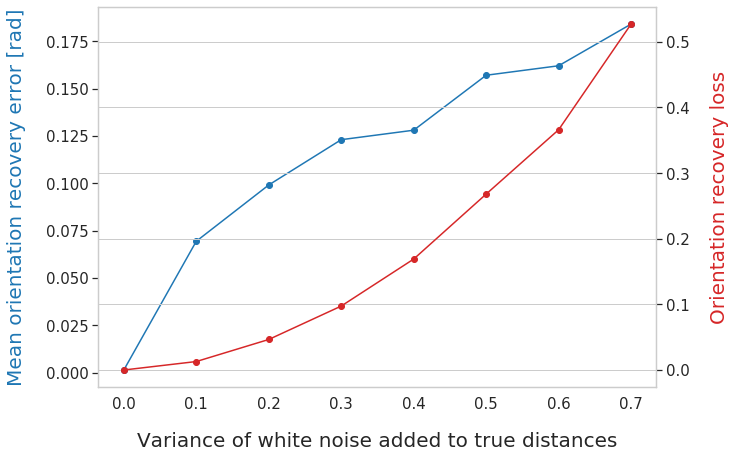

In [23]:
variances = [0.0, 
             0.1, 
             0.2, 
             0.3, 
             0.4, 
             0.5, 
             0.6, 
             0.7, 
             #0.8
            ]
losses = np.array([9.26e-09, 
                   1.29e-02, 
                   4.65e-02, 
                   9.74e-02, 
                   1.69e-01, 
                   2.68e-01, 
                   3.66e-01, 
                   5.27e-01, 
                   #6.39e-01
                  ])
# mean
#aa_losses = np.array([2.49e-03, 7.23e-02, 1.06e-01, 1.26e-01, 1.45e-01, 1.62e-01, 1.80e-01, 1.88e-01, 2.04e-1])
# median
aa_losses = np.array([1.47e-03, 
                      6.94e-02, 
                      9.91e-02, 
                      1.23e-01, 
                      1.28e-01, 
                      1.57e-01, 
                      1.62e-01, 
                      1.84e-01, 
                      #1.94e-01
                     ])
tick_size=15
labelpad = 20
label_size = 20

fig, ax = plt.subplots(1, 1, figsize=(10,7))
ax.set_xlabel('Variance of white noise added to true distances', fontsize=label_size, labelpad=labelpad)
ax.plot(variances, aa_losses, marker="o", color='tab:blue')
ax.set_ylabel(f'Mean orientation recovery error [rad]', color='tab:blue', fontsize=label_size, labelpad=labelpad)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
ax.grid()

ax2 = ax.twinx()
ax2.plot(variances, losses, marker="o", color='tab:red')
ax2.set_ylabel(f'Orientation recovery loss', color='tab:red', fontsize=label_size, labelpad=labelpad)
ax2.tick_params(axis='both', which='major', labelsize=tick_size)


#fig.savefig("test.png")
plt.show()

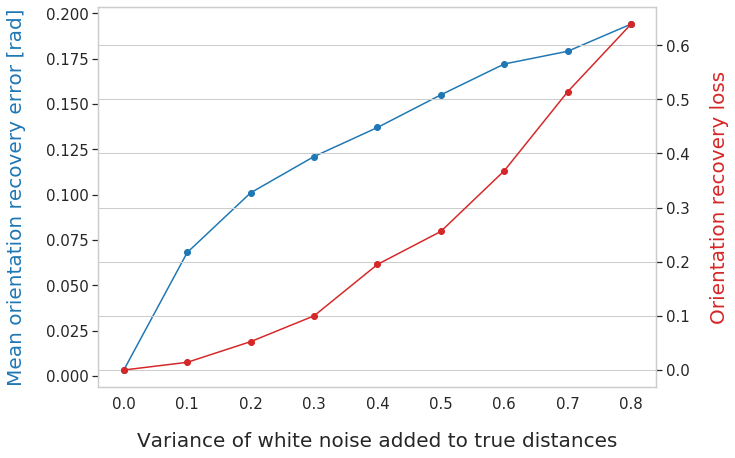

In [24]:

# losses
variances = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
losses = np.array([1.42e-08, 1.42e-02, 5.24e-02, 1.00e-01, 1.95e-01, 2.56e-01, 3.68e-01, 5.14e-01, 6.39e-01])
# mean
#aa_losses = np.array([2.49e-03, 7.23e-02, 1.06e-01, 1.26e-01, 1.45e-01, 1.62e-01, 1.80e-01, 1.88e-01, 2.04e-1])
# median
aa_losses = np.array([3.33e-03, 6.81e-02, 1.01e-01, 1.21e-01, 1.37e-01, 1.55e-01, 1.72e-01, 1.79e-01, 1.94e-01])

tick_size=15
labelpad = 20
label_size = 20

fig, ax = plt.subplots(1, 1, figsize=(10,7))
ax.set_xlabel('Variance of white noise added to true distances', fontsize=label_size, labelpad=labelpad)
ax.plot(variances, aa_losses, marker="o", color='tab:blue')
ax.set_ylabel(f'Mean orientation recovery error [rad]', color='tab:blue', fontsize=label_size, labelpad=labelpad)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
ax.grid()

ax2 = ax.twinx()
ax2.plot(variances, losses, marker="o", color='tab:red')
ax2.set_ylabel(f'Orientation recovery loss', color='tab:red', fontsize=label_size, labelpad=labelpad)
ax2.tick_params(axis='both', which='major', labelsize=tick_size)


#fig.savefig("test.png")
plt.show()

---

In [31]:
data = np.load("/mnt/scratch/students/angle_recovery_5j0n_perfect.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)

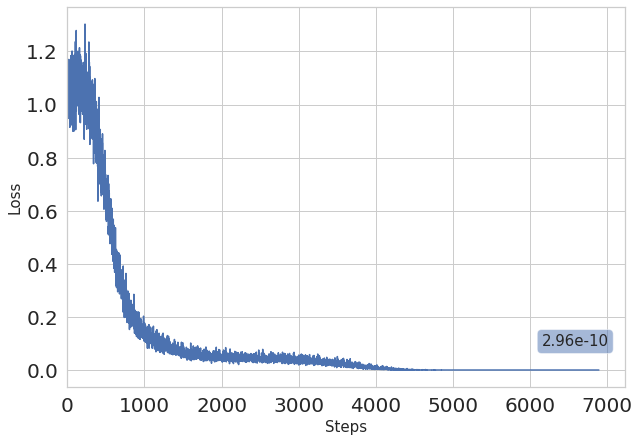

In [32]:
losses_plot = losses[losses!=0]

fig, ax = plt.subplots(figsize=(10,7))
plt.plot(losses_plot) # np.arange(0., 0.474*len(losses[losses>1e-5]), 0.474),
plt.xlabel("Steps", fontsize=tick_size)
plt.ylabel("Loss", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_xlim(0)
#ax.set_ylim(0)

props = dict(boxstyle='round', facecolor='b', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.85, 0.14, f"{np.mean(losses_plot[-10:]):.2e}", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

plt.show()

In [34]:
#np.save("data/5j0n/projections_limited2.5_estimated_50k", projections)
#np.save("data/5j0n/angles_true_limited2.5_estimated_50k", angles_true)
np.save("/mnt/scratch/students/angles_predicted_5a1a_perfect", angles_predicted)

In [253]:
rerun=False

In [254]:
if rerun:
    m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                            steps=300, 
                                                            batch_size=256, 
                                                            optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                            angles_true=angles_true[test_idx], 
                                                            angles_predicted=np.array(angles_predicted)[test_idx])
    m = m
    trajectory_first = trajectory[0]
    loss_first = losses[0]
    trajectory_last = trajectory[-1]
    loss_last = losses[-1]
else:
    m = [1.0, 1.0, 1.0, -1.0]
    trajectory_first = [2.47563219, 5.69811954, 0.95310088, 4.90004713, 1.99233072, 0.12931273]
    loss_first = 2.1487225317189007
    trajectory_last = [-4.66935956e+01,  4.34691197e+01,  8.62449480e+00,  1.27628528e+01, 3.60803354e-03,  6.73013414e+00]
    loss_last = 0.00020451586345109828

In [37]:
m, trajectory_first, loss_first, trajectory_last, loss_last

([1.0, 1.0, 1.0, -1.0],
 [2.47563219, 5.69811954, 0.95310088, 4.90004713, 1.99233072, 0.12931273],
 2.1487225317189007,
 [-46.6935956, 43.4691197, 8.6244948, 12.7628528, 0.00360803354, 6.73013414],
 0.00020451586345109828)

Text(0.63, 0.98, '2.1487 rad')

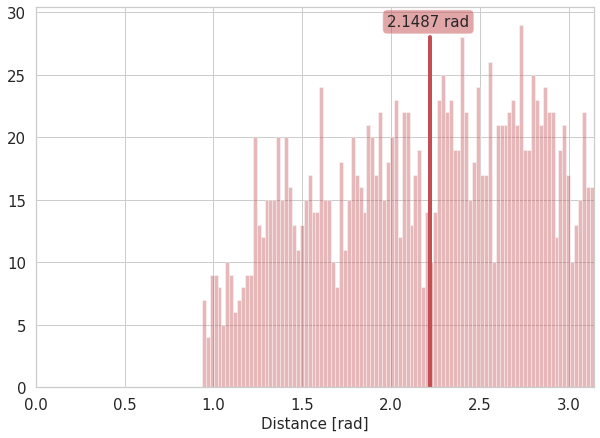

In [57]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
q_predicted_rot = update_quaternion(m, [tf.Variable(trajectory_first)], q_predicted)
d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=100, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.63, 0.98, f"{loss_first:.4f} rad", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

Text(0.01, 0.99, '0.0002 rad')

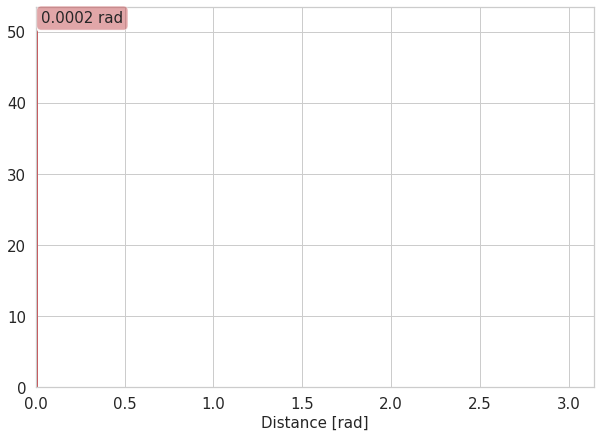

In [56]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
q_predicted_rot = update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted)
d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=100, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.01, 0.99, f"{loss_last:.4f} rad", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

In [264]:
data = np.load("/mnt/scratch/students/angle_recovery_5j0n_perfect.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)

In [265]:
from cryoem.plots import plot_only_selected_in_euclidean_space

In [266]:
import ipyvolume as ipv
from cryoem.rotation_matrices import RotationMatrix

In [273]:
selected = range(1650)
ipv.clear()
aps = RotationMatrix(np.take(angles_predicted, selected, axis=0))[:,:3]
ats = RotationMatrix(np.take(angles_true, selected, axis=0))[:,:3]
connections = np.empty((len(selected)*2, 2,3))
connections[:] = np.nan
connections[::2] = np.stack([ats, aps],axis=1)

ipv.scatter(ats[:,0], ats[:,1], ats[:,2], marker="sphere", color="green", size=1)
ipv.scatter(aps[:,0], aps[:,1], aps[:,2], marker="sphere", color="red", size=1)
#ipv.plot(connections[:,:,0].flatten(),connections[:,:,1].flatten(), connections[:,:,2].flatten(),color="red", lynestyle="--")
ipv.xlim(-1, 1);ipv.ylim(-1,1);ipv.zlim(-1, 1)
ipv.show()


In [269]:
q_predicted_rot = update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted)
angles_predicted_rot = quaternion2euler(q_predicted_rot)

In [272]:
selected = range(1650)
ipv.clear()
aps = RotationMatrix(np.take(angles_predicted_rot, selected, axis=0))[:,:3]
ats = RotationMatrix(np.take(angles_true, selected, axis=0))[:,:3]
connections = np.empty((len(selected)*2, 2,3))
connections[:] = np.nan
connections[::2] = np.stack([ats, aps],axis=1)

ipv.scatter(ats[:,0], ats[:,1], ats[:,2], marker="sphere", color="green", size=1)
ipv.scatter(aps[:,0], aps[:,1], aps[:,2], marker="sphere", color="red", size=1)
#ipv.plot(connections[:,:,0].flatten(),connections[:,:,1].flatten(), connections[:,:,2].flatten(),color="red", lynestyle="--")
ipv.xlim(-1, 1);ipv.ylim(-1,1);ipv.zlim(-1, 1)
ipv.show()


---

In [82]:
data = np.load("/mnt/scratch/students/angle_recovery_5a1a_perfect.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)

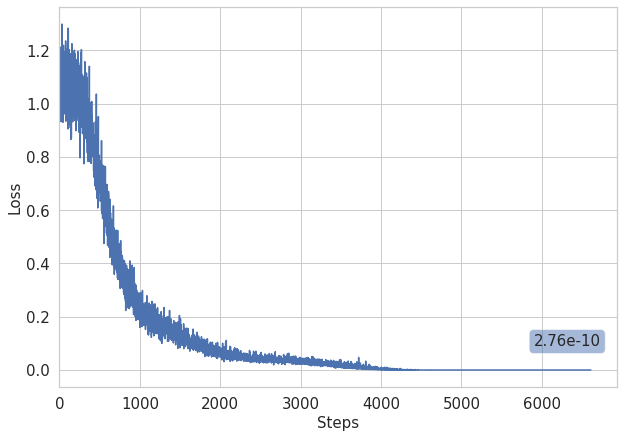

In [83]:
losses_plot = losses[losses!=0]

fig, ax = plt.subplots(figsize=(10,7))
plt.plot(losses_plot) # np.arange(0., 0.474*len(losses[losses>1e-5]), 0.474),
plt.xlabel("Steps", fontsize=tick_size)
plt.ylabel("Loss", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_xlim(0)
#ax.set_ylim(0)

props = dict(boxstyle='round', facecolor='b', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.85, 0.14, f"{np.mean(losses_plot[-10:]):.2e}", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

plt.show()

# 5j0n

In [8]:
PROTEIN="5j0n"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [9]:
# location of *.h5 files
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [10]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

In [11]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

In [12]:
from skimage.transform import resize

def rescale_image(image):
    c = image.shape[-1]/117
    image_resized = resize(image, (image.shape[0] // c, image.shape[1] // c), anti_aliasing=True)
    return image_resized

In [13]:
projections_new = []
for p in projections:
    projections_new.append(rescale_image(p))
projections_new = np.array(projections_new)
projections_new.shape

(5000, 116, 116)

In [14]:
from cryoem.distance_estimation import global_standardization

In [15]:
X, y = np.array(projections_new, dtype=np.float32), np.array(angles_true, dtype=np.float32)

In [16]:
X = global_standardization(X)

Image shape: (116, 116)
Data Type: float32
***
Mean: 0.262 | Std: 1.046
Min:  0.000 | Max: 15.458
Mean: 0.000 | Std: 1.000
Min:  -0.250 | Max: 14.526


In [17]:
channels = "gray"
if channels == "rgb":
    X = np.stack((X,)*3, axis=-1)
elif channels == "gray":
    X = X[:,:,:,np.newaxis]

In [18]:
X.shape

(5000, 116, 116, 1)

In [19]:
model_filename = f"/mnt/scratch/students/noisy_var0.h5"

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [20]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ

In [21]:
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=512)

In [22]:
batch_size = 512
idx1 = list(np.random.choice(range(5000), size=batch_size))
idx2 = list(np.random.choice(range(5000), size=batch_size))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

In [24]:
import pandas as pd

<Figure size 432x288 with 0 Axes>

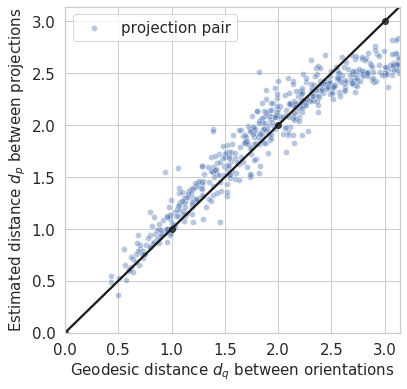

In [45]:
plt.clf()
# Creating the dataframe for SNS plot
data = {"d_Q" : dQ_values, #tr_y.numpy(),
        "d_P" : dP_values } #y_tr_pred.T[0]}
df1 = pd.DataFrame(data=data)

# Creating the dataframe for SNS plot
# data = {"d_Q" : val_y.numpy(),
#         "d_P" : y_val_pred.T[0]}
# df2 = pd.DataFrame(data=data)

plt.clf();
fig, ax = plt.subplots(1, 1, figsize=(6,6));
sns.scatterplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.4, label="projection pair", ax=ax);  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
sns.regplot(x=x, y=x, color="k", ax=ax)
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
plt.xlabel("Geodesic distance $d_q$ between orientations", fontsize=tick_size)
plt.ylabel("Estimated distance $d_p$ between projections", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.legend(loc=2, fontsize=15)
plt.show();

# 5a1a

In [99]:
PROTEIN="5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [100]:
# location of *.h5 files
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,0.5_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (275, 275) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [101]:
projections = data['Projections']
projections.shape

(5000, 275, 275)

In [102]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

In [103]:
from skimage.transform import resize

def rescale_image(image):
    c = image.shape[-1]/117
    image_resized = resize(image, (image.shape[0] // c, image.shape[1] // c), anti_aliasing=True)
    return image_resized

In [104]:
projections_new = []
for p in projections:
    projections_new.append(rescale_image(p))
projections_new = np.array(projections_new)
projections_new.shape

(5000, 116, 116)

In [105]:
from cryoem.distance_estimation import global_standardization

In [106]:
X, y = np.array(projections_new, dtype=np.float32), np.array(angles_true, dtype=np.float32)

In [107]:
X = global_standardization(X)

Image shape: (116, 116)
Data Type: float32
***
Mean: 2.955 | Std: 7.368
Min:  0.000 | Max: 74.906
Mean: 0.000 | Std: 1.000
Min:  -0.401 | Max: 9.766


In [108]:
channels = "gray"
if channels == "rgb":
    X = np.stack((X,)*3, axis=-1)
elif channels == "gray":
    X = X[:,:,:,np.newaxis]

In [109]:
X.shape

(5000, 116, 116, 1)

In [117]:
model_filename = f"/mnt/scratch/students/noisy_var0_5a1a.h5"

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [118]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ

In [119]:
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=512)

In [123]:
# 5:41 with 1024
# 5:43     with 256
idx1 = list(np.random.choice(test_idx, size=1000))
idx2 = list(np.random.choice(test_idx, size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

In [124]:
import pandas as pd

<Figure size 432x288 with 0 Axes>

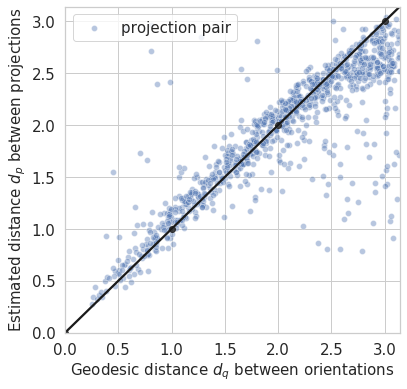

In [152]:
plt.clf()
# Creating the dataframe for SNS plot
data = {"d_Q" : dQ_values, #tr_y.numpy(),
        "d_P" : dP_values } #y_tr_pred.T[0]}
df1 = pd.DataFrame(data=data)

# Creating the dataframe for SNS plot
# data = {"d_Q" : val_y.numpy(),
#         "d_P" : y_val_pred.T[0]}
# df2 = pd.DataFrame(data=data)

plt.clf();
fig, ax = plt.subplots(1, 1, figsize=(6,6));
sns.scatterplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.4, label="projection pair", ax=ax);  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
sns.regplot(x=x, y=x, color="k", ax=ax)
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
plt.xlabel("Geodesic distance $d_q$ between orientations", fontsize=tick_size)
plt.ylabel("Estimated distance $d_p$ between projections", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.legend(loc=2, fontsize=15)
plt.show();

---

In [214]:
df0_train = pd.read_csv("/mnt/scratch/students/run-noisy_var0_train-tag-epoch_loss.csv")
df0_train["noise_variance"] = df0_train.apply(lambda x: 0, axis=1)
df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)

df0_val = pd.read_csv("/mnt/scratch/students/run-noisy_var0_validation-tag-epoch_loss.csv")
df0_val["noise_variance"] = df0_val.apply(lambda x: 0, axis=1)
df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)

In [215]:
label_size = 20
tick_size = 15

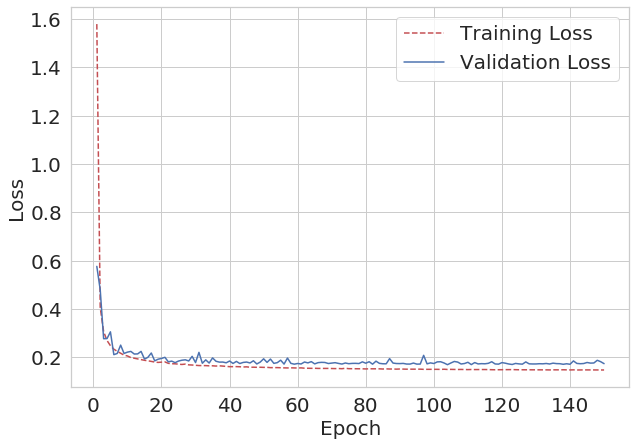

In [216]:
# Get training and test loss histories
training_loss = df0_train['Value'].values
val_loss = df0_val['Value'].values

fig, ax = plt.subplots(figsize=(10,7))

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
ax.plot(epoch_count, training_loss, 'r--', label='Training Loss')
ax.plot(epoch_count, val_loss, 'b-', label='Validation Loss')
ax.set_xlabel('Epoch', fontsize=label_size)
ax.set_ylabel('Loss', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.legend(loc=1, fontsize=20)

plt.show();

In [217]:
df0_train = pd.read_csv("/mnt/scratch/students/run-noisy_var0_5a1a_train-tag-epoch_loss.csv")
df0_train["noise_variance"] = df0_train.apply(lambda x: 0, axis=1)
df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)

df0_val = pd.read_csv("/mnt/scratch/students/run-noisy_var0_5a1a_validation-tag-epoch_loss.csv")
df0_val["noise_variance"] = df0_val.apply(lambda x: 0, axis=1)
df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)

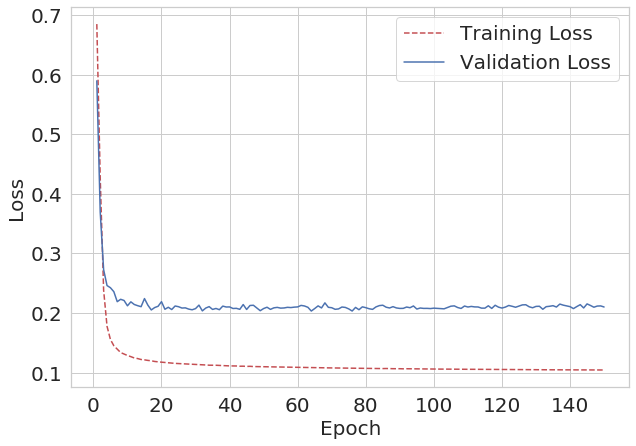

In [218]:
# Get training and test loss histories
training_loss = df0_train['Value'].values[78:228]
val_loss = df0_val['Value'].values[78:228]

fig, ax = plt.subplots(figsize=(10,7))

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
ax.plot(epoch_count, training_loss, 'r--', label='Training Loss')
ax.plot(epoch_count, val_loss, 'b-', label='Validation Loss')
ax.set_xlabel('Epoch', fontsize=label_size)
ax.set_ylabel('Loss', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.legend(loc=1, fontsize=20)

plt.show();

# Euclidean vs. Geodesic vs. MLP

In [30]:
import pandas as pd

In [45]:
df_geo_train = pd.read_csv("/mnt/scratch/students/run-cosine_distance_metric_train-tag-epoch_loss.csv")
df_geo_train["distance_metric"] = df_geo_train.apply(lambda x: "Geodesic", axis=1)
df_geo_train["dataset"] = df_geo_train.apply(lambda x: "train", axis=1)

df_geo_val = pd.read_csv("/mnt/scratch/students/run-cosine_distance_metric_validation-tag-epoch_loss.csv")
df_geo_val["distance_metric"] = df_geo_val.apply(lambda x: "Geodesic", axis=1)
df_geo_val["dataset"] = df_geo_val.apply(lambda x: "validation", axis=1)


df_eucl_train = pd.read_csv("/mnt/scratch/students/run-euclidean_distance_metric_train-tag-epoch_loss.csv")
df_eucl_train["distance_metric"] = df_eucl_train.apply(lambda x: "Euclidean", axis=1)
df_eucl_train["dataset"] = df_eucl_train.apply(lambda x: "train", axis=1)

df_eucl_val = pd.read_csv("/mnt/scratch/students/run-euclidean_distance_metric_validation-tag-epoch_loss.csv")
df_eucl_val["distance_metric"] = df_eucl_val.apply(lambda x: "Euclidean", axis=1)
df_eucl_val["dataset"] = df_eucl_val.apply(lambda x: "validation", axis=1)


df_mlp_train = pd.read_csv("/mnt/scratch/students/run-mlp_distance_metric_train-tag-epoch_loss.csv")
df_mlp_train["distance_metric"] = df_mlp_train.apply(lambda x: "MLP", axis=1)
df_mlp_train["dataset"] = df_mlp_train.apply(lambda x: "train", axis=1)

df_mlp_val = pd.read_csv("/mnt/scratch/students/run-mlp_distance_metric_validation-tag-epoch_loss.csv")
df_mlp_val["distance_metric"] = df_mlp_val.apply(lambda x: "MLP", axis=1)
df_mlp_val["dataset"] = df_mlp_val.apply(lambda x: "validation", axis=1)

In [46]:
df = pd.concat([eval(f"df_{dm}_{ds}") for dm in ["geo", "eucl", "mlp"] for ds in ["train", "val"]])

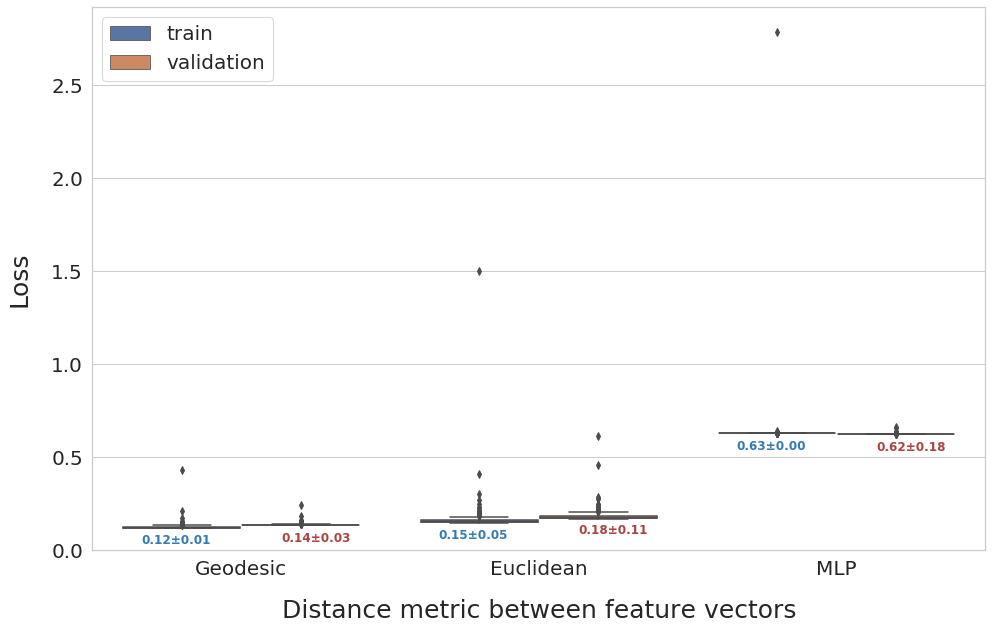

In [119]:
fig, ax = plt.subplots(figsize=(16,10))

mapping = {0:"Geodesic", 1:"Euclidean", 2:"MLP"}

box_plot = sns.boxplot(x="distance_metric", y="Value", hue="dataset", data=df, ax=ax)
box_plot.tick_params(labelsize=20)
ax.set_xlabel("Distance metric between feature vectors", fontsize=25, labelpad=20);
ax.set_ylabel("Loss", fontsize=25, labelpad=20);
ax.set_ylim(0)
ax.legend(loc=2, fontsize=20)

medians_na = df[df.dataset=='train'].groupby(['distance_metric'])['Value'].median()#.sort_values(ascending=False)
stds_na = df[df.dataset=='train'].groupby(['distance_metric'])['Value'].std()
vertical_offset_na = df[df.dataset=='validation']['Value'].median() * 0.5 # offset from median for display
horizontal_offset = 0.25

for xtick in box_plot.get_xticks():
    box_plot.text(xtick+horizontal_offset, 
                  medians[mapping[xtick]] - vertical_offset, 
                  f"{medians[mapping[xtick]]:.2f}±{stds_na[mapping[xtick]]:.2f}", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=12, color='#A94442')

medians = df[df.dataset=='validation'].groupby(['distance_metric'])['Value'].median()#.sort_values(ascending=False)
stds = df[df.dataset=='validation'].groupby(['distance_metric'])['Value'].std()
vertical_offset = df[df.dataset=='validation']['Value'].median() * 0.5 # offset from median for display
horizontal_offset = 0.22
for xtick in box_plot.get_xticks():
    box_plot.text(xtick-horizontal_offset, 
                  medians_na[mapping[xtick]] - vertical_offset_na, 
                  f"{medians_na[mapping[xtick]]:.2f}±{stds[mapping[xtick]]:.2f}", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=12, color='#337AB7')

In [67]:
PROTEIN="5j0n"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [68]:
# location of *.h5 files
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [69]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

In [70]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

In [71]:
from skimage.transform import resize

def rescale_image(image):
    c = image.shape[-1]/117
    image_resized = resize(image, (image.shape[0] // c, image.shape[1] // c), anti_aliasing=True)
    return image_resized

In [72]:
projections_new = []
for p in projections:
    projections_new.append(rescale_image(p))
projections_new = np.array(projections_new)
projections_new.shape

(5000, 116, 116)

In [73]:
from cryoem.distance_estimation import global_standardization

In [74]:
X, y = np.array(projections_new, dtype=np.float32), np.array(angles_true, dtype=np.float32)

In [75]:
X = global_standardization(X)

Image shape: (116, 116)
Data Type: float32
***
Mean: 0.262 | Std: 1.046
Min:  0.000 | Max: 15.458
Mean: 0.000 | Std: 1.000
Min:  -0.250 | Max: 14.526


In [76]:
channels = "gray"
if channels == "rgb":
    X = np.stack((X,)*3, axis=-1)
elif channels == "gray":
    X = X[:,:,:,np.newaxis]

In [77]:
X.shape

(5000, 116, 116, 1)

In [78]:
model_filename = f"/mnt/scratch/students/cosine_distance_metric.h5"

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [79]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ

In [80]:
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=512)

In [81]:
# 5:41 with 1024
# 5:43     with 256
idx1 = list(np.random.choice(test_idx, size=1000))
idx2 = list(np.random.choice(test_idx, size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

In [82]:
import pandas as pd

<Figure size 432x288 with 0 Axes>

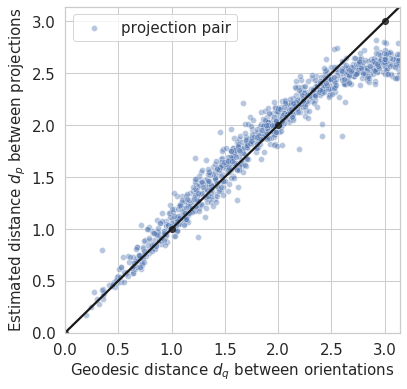

In [84]:
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
plt.clf()
# Creating the dataframe for SNS plot
data = {"d_Q" : dQ_values, #tr_y.numpy(),
        "d_P" : dP_values } #y_tr_pred.T[0]}
df1 = pd.DataFrame(data=data)

# Creating the dataframe for SNS plot
# data = {"d_Q" : val_y.numpy(),
#         "d_P" : y_val_pred.T[0]}
# df2 = pd.DataFrame(data=data)

plt.clf();
fig, ax = plt.subplots(1, 1, figsize=(6,6));
sns.scatterplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.4, label="projection pair", ax=ax);  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
sns.regplot(x=x, y=x, color="k", ax=ax)
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
plt.xlabel("Geodesic distance $d_q$ between orientations", fontsize=tick_size)
plt.ylabel("Estimated distance $d_p$ between projections", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.legend(loc=2, fontsize=15)
plt.show();

---

In [85]:
PROTEIN="5j0n"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [86]:
# location of *.h5 files
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [87]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

In [88]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

In [89]:
from skimage.transform import resize

def rescale_image(image):
    c = image.shape[-1]/117
    image_resized = resize(image, (image.shape[0] // c, image.shape[1] // c), anti_aliasing=True)
    return image_resized

In [90]:
projections_new = []
for p in projections:
    projections_new.append(rescale_image(p))
projections_new = np.array(projections_new)
projections_new.shape

(5000, 116, 116)

In [91]:
from cryoem.distance_estimation import global_standardization

In [92]:
X, y = np.array(projections_new, dtype=np.float32), np.array(angles_true, dtype=np.float32)

In [93]:
X = global_standardization(X)

Image shape: (116, 116)
Data Type: float32
***
Mean: 0.262 | Std: 1.046
Min:  0.000 | Max: 15.458
Mean: 0.000 | Std: 1.000
Min:  -0.250 | Max: 14.526


In [94]:
channels = "gray"
if channels == "rgb":
    X = np.stack((X,)*3, axis=-1)
elif channels == "gray":
    X = X[:,:,:,np.newaxis]

In [95]:
X.shape

(5000, 116, 116, 1)

In [96]:
model_filename = f"/mnt/scratch/students/euclidean_distance_metric.h5"

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [97]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ

In [98]:
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=512)

In [99]:
# 5:41 with 1024
# 5:43     with 256
idx1 = list(np.random.choice(test_idx, size=1000))
idx2 = list(np.random.choice(test_idx, size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

In [100]:
import pandas as pd

<Figure size 432x288 with 0 Axes>

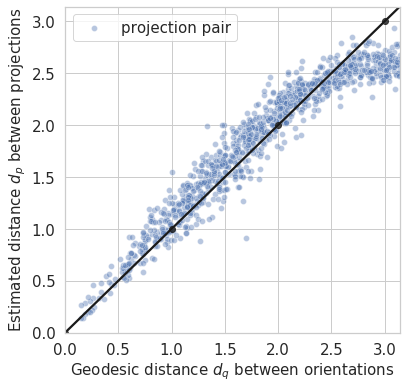

In [101]:
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
plt.clf()
# Creating the dataframe for SNS plot
data = {"d_Q" : dQ_values, #tr_y.numpy(),
        "d_P" : dP_values } #y_tr_pred.T[0]}
df1 = pd.DataFrame(data=data)

# Creating the dataframe for SNS plot
# data = {"d_Q" : val_y.numpy(),
#         "d_P" : y_val_pred.T[0]}
# df2 = pd.DataFrame(data=data)

plt.clf();
fig, ax = plt.subplots(1, 1, figsize=(6,6));
sns.scatterplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.4, label="projection pair", ax=ax);  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
sns.regplot(x=x, y=x, color="k", ax=ax)
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
plt.xlabel("Geodesic distance $d_q$ between orientations", fontsize=tick_size)
plt.ylabel("Estimated distance $d_p$ between projections", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.legend(loc=2, fontsize=15)
plt.show();

---

In [102]:
PROTEIN="5j0n"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [103]:
# location of *.h5 files
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [104]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

In [105]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

In [106]:
from skimage.transform import resize

def rescale_image(image):
    c = image.shape[-1]/117
    image_resized = resize(image, (image.shape[0] // c, image.shape[1] // c), anti_aliasing=True)
    return image_resized

In [107]:
projections_new = []
for p in projections:
    projections_new.append(rescale_image(p))
projections_new = np.array(projections_new)
projections_new.shape

(5000, 116, 116)

In [108]:
from cryoem.distance_estimation import global_standardization

In [109]:
X, y = np.array(projections_new, dtype=np.float32), np.array(angles_true, dtype=np.float32)

In [110]:
X = global_standardization(X)

Image shape: (116, 116)
Data Type: float32
***
Mean: 0.262 | Std: 1.046
Min:  0.000 | Max: 15.458
Mean: 0.000 | Std: 1.000
Min:  -0.250 | Max: 14.526


In [111]:
channels = "gray"
if channels == "rgb":
    X = np.stack((X,)*3, axis=-1)
elif channels == "gray":
    X = X[:,:,:,np.newaxis]

In [112]:
X.shape

(5000, 116, 116, 1)

In [113]:
model_filename = f"/mnt/scratch/students/mlp_distance_metric.h5"

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 1024)         0           model[1][0]                

In [114]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ

In [115]:
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=512)

In [116]:
# 5:41 with 1024
# 5:43     with 256
idx1 = list(np.random.choice(test_idx, size=1000))
idx2 = list(np.random.choice(test_idx, size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

In [117]:
import pandas as pd

<Figure size 432x288 with 0 Axes>

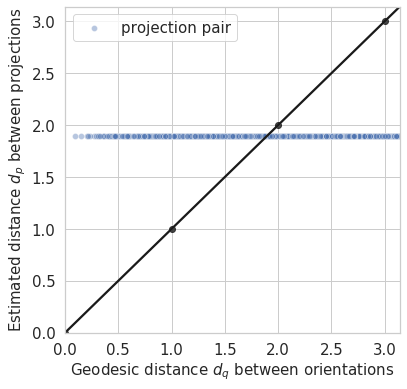

In [118]:
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
plt.clf()
# Creating the dataframe for SNS plot
data = {"d_Q" : dQ_values, #tr_y.numpy(),
        "d_P" : dP_values } #y_tr_pred.T[0]}
df1 = pd.DataFrame(data=data)

# Creating the dataframe for SNS plot
# data = {"d_Q" : val_y.numpy(),
#         "d_P" : y_val_pred.T[0]}
# df2 = pd.DataFrame(data=data)

plt.clf();
fig, ax = plt.subplots(1, 1, figsize=(6,6));
sns.scatterplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.4, label="projection pair", ax=ax);  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
sns.regplot(x=x, y=x, color="k", ax=ax)
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
plt.xlabel("Geodesic distance $d_q$ between orientations", fontsize=tick_size)
plt.ylabel("Estimated distance $d_p$ between projections", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.legend(loc=2, fontsize=15)
plt.show();

---

# Var 0

In [81]:
data = np.load("/mnt/scratch/students/angle_recovery_limited3.14_estimated_noisy0.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)

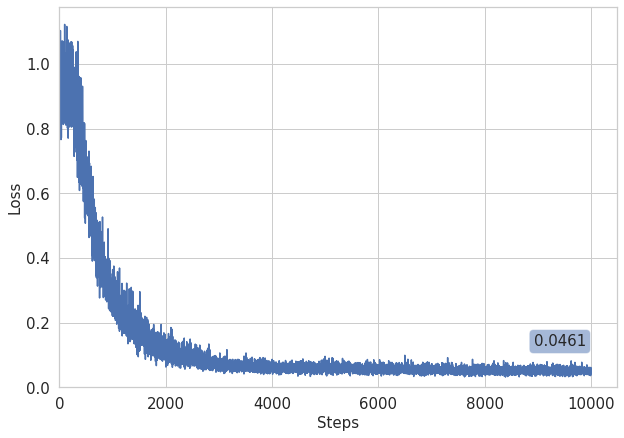

In [82]:
losses_plot = losses[:10000]

fig, ax = plt.subplots(figsize=(10,7))
plt.plot(losses_plot) # np.arange(0., 0.474*len(losses[losses>1e-5]), 0.474),
plt.xlabel("Steps", fontsize=tick_size)
plt.ylabel("Loss", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_xlim(0)
ax.set_ylim(0)

props = dict(boxstyle='round', facecolor='b', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.85, 0.14, f"{np.mean(losses_plot[-10:]):.4f}", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

plt.show()

In [83]:
rerun=True

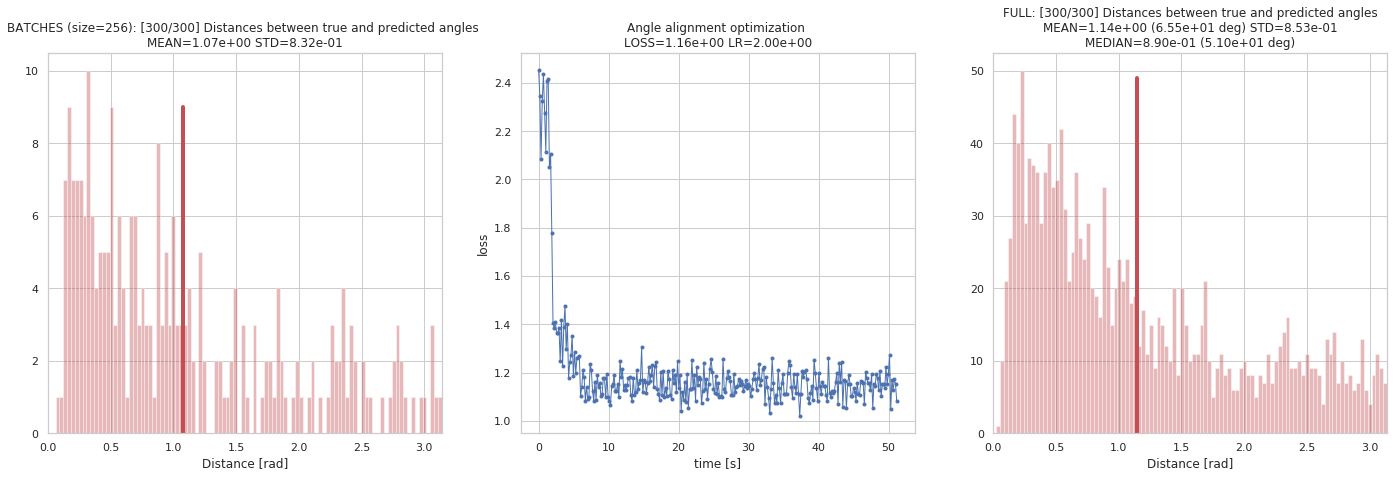

step 30/300 (7s): loss = 1.71e+00
step 60/300 (12s): loss = 1.16e+00
step 90/300 (17s): loss = 1.15e+00
step 120/300 (22s): loss = 1.16e+00
step 150/300 (27s): loss = 1.15e+00
step 180/300 (32s): loss = 1.15e+00
step 210/300 (37s): loss = 1.15e+00
step 240/300 (42s): loss = 1.15e+00
step 270/300 (47s): loss = 1.14e+00
step 300/300 (52s): loss = 1.16e+00



In [84]:
if rerun:
    m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                            steps=300, 
                                                            batch_size=256, 
                                                            optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                            angles_true=angles_true[test_idx], 
                                                            angles_predicted=np.array(angles_predicted))
    m = m
    trajectory_first = trajectory[0]
    loss_first = losses[0]
    trajectory_last = trajectory[-1]
    loss_last = losses[-1]
else:
    pass
#     m = [1.0, 1.0, 1.0, -1.0]
#     trajectory_first = [1.55300104, 2.81036984, 5.2178074 , 0.18295697, 2.11496371, 3.09141405]
#     loss_first = 2.661634550544549
#     trajectory_last = [ 8.34225157, 20.60956391, 19.13156328, 11.4381577 ,  2.8817712 , 16.02597525]
#     loss_last = 0.418361192772094

In [85]:
m, trajectory_first, loss_first, trajectory_last, loss_last

([1.0, 1.0, 1.0, -1.0],
 array([2.73731412, 1.98068441, 3.04126997, 4.05004841, 4.40596428,
        5.33218377]),
 2.4530434839066455,
 array([-21.33906981,  22.05614957,  12.34155119,  -8.76589966,
         -0.05384454,  45.96745246]),
 1.0825888471122755)

Text(0.77, 0.72, '$E$ = 2.4530 rad')

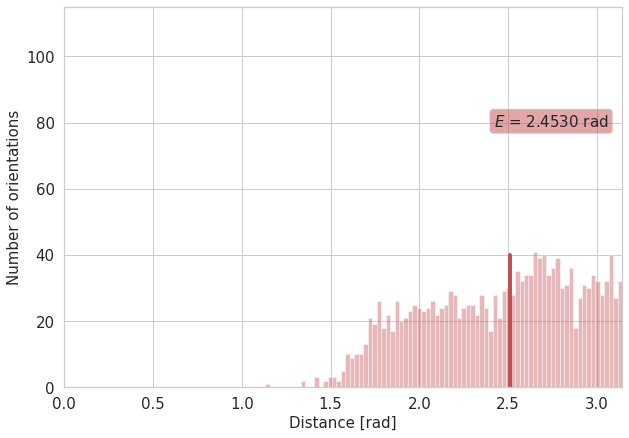

In [86]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
q_predicted_rot = update_quaternion(m, [tf.Variable(trajectory_first)], q_predicted)
d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 115)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=80, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.77, 0.72, f"$E$ = {loss_first:.4f} rad", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

Text(0.03, 0.95, '$E$ = 1.0826 rad')

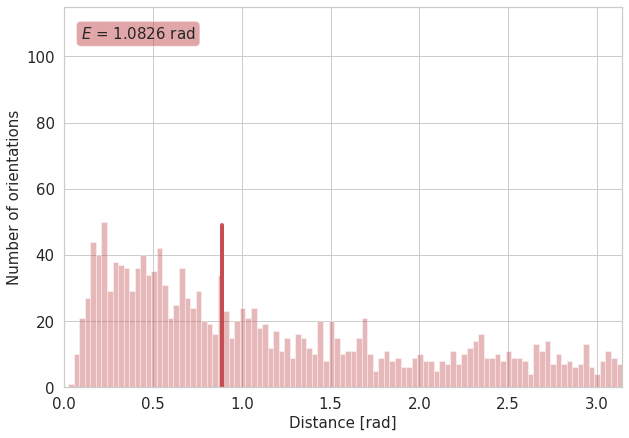

In [87]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
q_predicted_rot = update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted)
d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 115)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=100, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.03, 0.95, f"$E$ = {loss_last:.4f} rad", transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)

---

# Var 5

In [16]:
#data = np.load("/mnt/scratch/students/angle_recovery_limited3.14_estimated_noisy5.npz")
data = np.load("/mnt/scratch/students/angle_recovery_noisy5_limited3.14_estimated_50k.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)

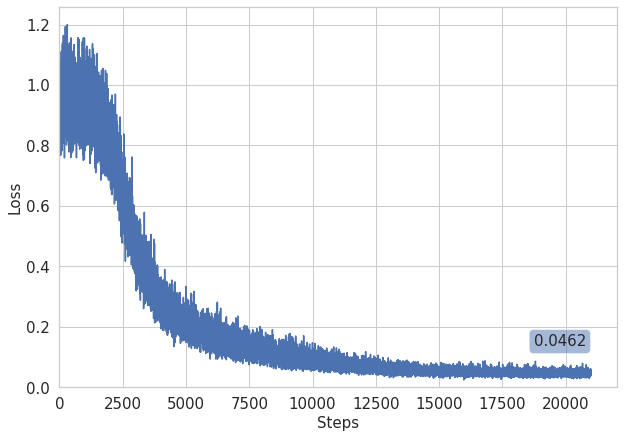

In [21]:
losses_plot = losses[:21000]

fig, ax = plt.subplots(figsize=(10,7))
plt.plot(losses_plot) # np.arange(0., 0.474*len(losses[losses>1e-5]), 0.474),
plt.xlabel("Steps", fontsize=tick_size)
plt.ylabel("Loss", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_xlim(0)
ax.set_ylim(0)

props = dict(boxstyle='round', facecolor='b', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.85, 0.14, f"{np.mean(losses_plot[-10:]):.4f}", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

plt.show()

In [22]:
rerun=True

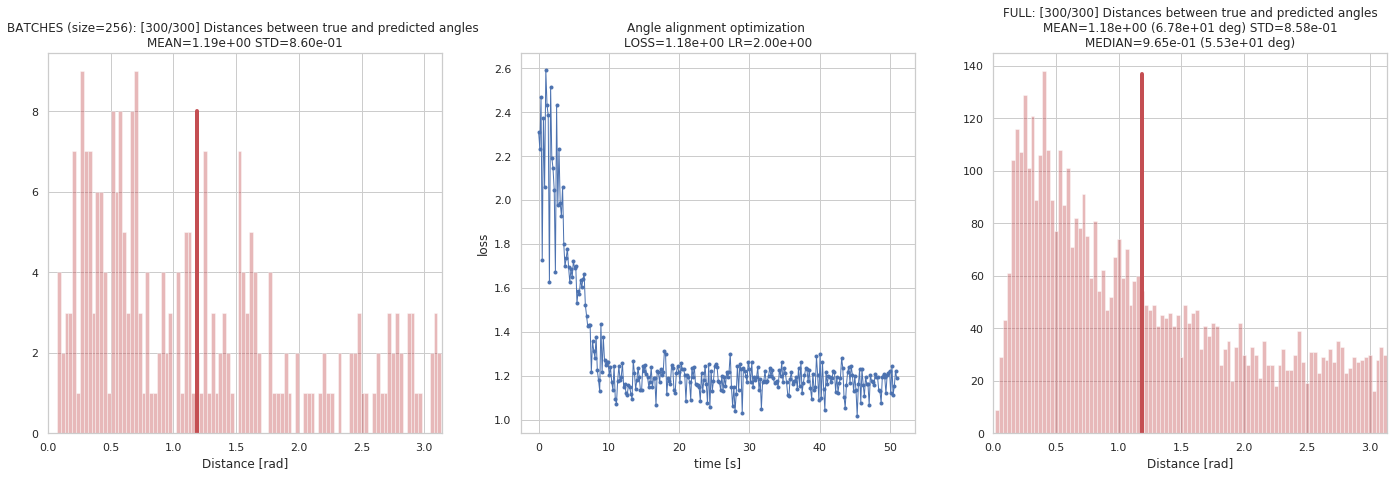

step 30/300 (5s): loss = 2.04e+00
step 60/300 (10s): loss = 1.42e+00
step 90/300 (15s): loss = 1.17e+00
step 120/300 (22s): loss = 1.20e+00
step 150/300 (27s): loss = 1.18e+00
step 180/300 (32s): loss = 1.18e+00
step 210/300 (37s): loss = 1.19e+00
step 240/300 (42s): loss = 1.19e+00
step 270/300 (47s): loss = 1.18e+00
step 300/300 (52s): loss = 1.17e+00



In [24]:
if rerun:
    m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                            steps=300, 
                                                            batch_size=256, 
                                                            optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                            angles_true=angles_true, 
                                                            angles_predicted=np.array(angles_predicted))
    m = m
    trajectory_first = trajectory[0]
    loss_first = losses[0]
    trajectory_last = trajectory[-1]
    loss_last = losses[-1]
else:
    pass
#     m = [1.0, 1.0, 1.0, -1.0]
#     trajectory_first = [1.55300104, 2.81036984, 5.2178074 , 0.18295697, 2.11496371, 3.09141405]
#     loss_first = 2.661634550544549
#     trajectory_last = [ 8.34225157, 20.60956391, 19.13156328, 11.4381577 ,  2.8817712 , 16.02597525]
#     loss_last = 0.418361192772094

In [25]:
m, trajectory_first, loss_first, trajectory_last, loss_last

([1.0, 1.0, 1.0, -1.0],
 array([5.47157613, 0.82295749, 3.68587794, 1.88273252, 5.65079047,
        2.10477014]),
 1.9625284414451756,
 array([ 9.43652309, -3.44863403, 15.14945606,  8.94017266, 19.09995206,
        14.12580706]),
 1.1680857516288239)

Text(0.77, 0.72, '$E$ = 1.9625 rad')

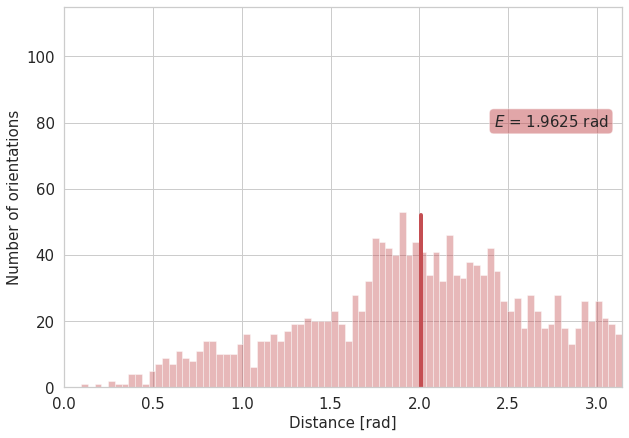

In [26]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
q_predicted_rot = update_quaternion(m, [tf.Variable(trajectory_first)], q_predicted[test_idx])
d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 115)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=80, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.77, 0.72, f"$E$ = {loss_first:.4f} rad", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

Text(0.03, 0.95, '$E$ = 1.1681 rad')

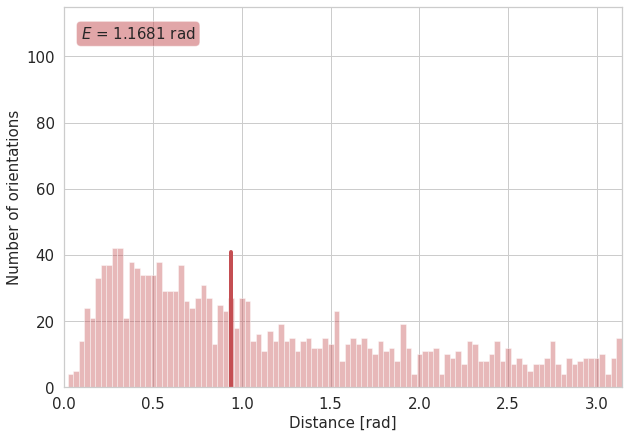

In [27]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
q_predicted_rot = update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted[test_idx])
d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 115)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=100, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.03, 0.95, f"$E$ = {loss_last:.4f} rad", transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)

---

# Var 10

In [28]:
data = np.load("/mnt/scratch/students/angle_recovery_noisy10_limited3.14_estimated_50k.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)

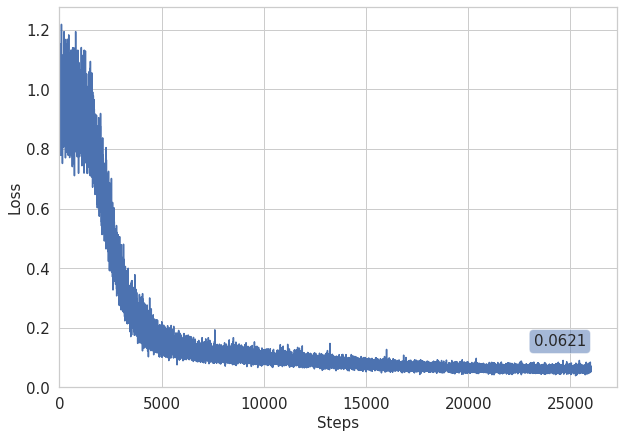

In [33]:
losses_plot = losses[:26000]

fig, ax = plt.subplots(figsize=(10,7))
plt.plot(losses_plot) # np.arange(0., 0.474*len(losses[losses>1e-5]), 0.474),
plt.xlabel("Steps", fontsize=tick_size)
plt.ylabel("Loss", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_xlim(0)
ax.set_ylim(0)

props = dict(boxstyle='round', facecolor='b', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.85, 0.14, f"{np.mean(losses_plot[-10:]):.4f}", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

plt.show()

In [34]:
rerun=False

In [35]:
if rerun:
    m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                            steps=300, 
                                                            batch_size=256, 
                                                            optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                            angles_true=angles_true[test_idx], 
                                                            angles_predicted=np.array(angles_predicted))
    m = m
    trajectory_first = trajectory[0]
    loss_first = losses[0]
    trajectory_last = trajectory[-1]
    loss_last = losses[-1]
else:
    m = [1.0, 1.0, 1.0, -1.0],
    trajectory_first = [0.67620082, 3.77936189, 5.99719574, 3.82700935, 3.98283373, 0.83755652]
    loss_first = 2.1650673107802643
    trajectory_last = [-15.73047063, -31.87331519,  -5.90083027,  16.01779536,14.936138  ,  -0.98924823]
    loss_last = 0.2315150295360849
#     m = [1.0, 1.0, 1.0, -1.0]
#     trajectory_first = [1.55300104, 2.81036984, 5.2178074 , 0.18295697, 2.11496371, 3.09141405]
#     loss_first = 2.661634550544549
#     trajectory_last = [ 8.34225157, 20.60956391, 19.13156328, 11.4381577 ,  2.8817712 , 16.02597525]
#     loss_last = 0.418361192772094

In [36]:
m, trajectory_first, loss_first, trajectory_last, loss_last

(([1.0, 1.0, 1.0, -1.0],),
 [0.67620082, 3.77936189, 5.99719574, 3.82700935, 3.98283373, 0.83755652],
 2.1650673107802643,
 [-15.73047063,
  -31.87331519,
  -5.90083027,
  16.01779536,
  14.936138,
  -0.98924823],
 0.2315150295360849)

(5000, 4)
(1650, 4)


Text(0.77, 0.72, '$E$ = 2.1651 rad')

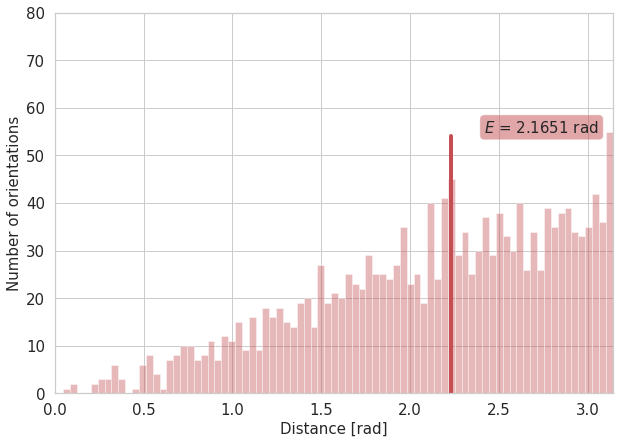

In [41]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
print(q_predicted.shape)
q_predicted_rot = np.squeeze(update_quaternion(m, [tf.Variable(trajectory_first)], q_predicted[test_idx]))
print(q_predicted_rot.shape)
d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 80)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=80, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.77, 0.72, f"$E$ = {loss_first:.4f} rad", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

Text(0.03, 0.95, '$E$ = 0.2315 rad')

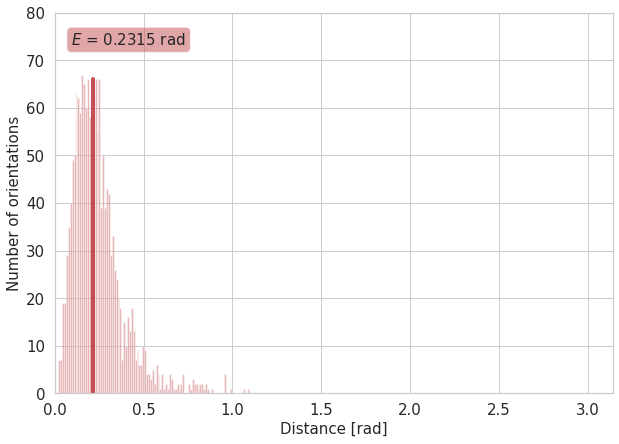

In [40]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
q_predicted_rot = np.squeeze(update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted[test_idx]))
d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 80)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=100, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.03, 0.95, f"$E$ = {loss_last:.4f} rad", transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)

---

# Var 20

In [66]:
#data = np.load("/mnt/scratch/students/angle_recovery_limited3.14_estimated_noisy20.npz")
data = np.load("/mnt/scratch/students/angle_recovery_noisy20_limited3.14_estimated_50k.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)

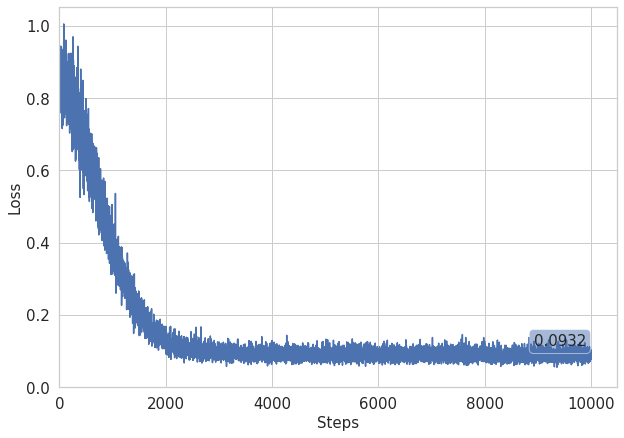

In [68]:
losses_plot = losses[:10000]

fig, ax = plt.subplots(figsize=(10,7))
plt.plot(losses_plot) # np.arange(0., 0.474*len(losses[losses>1e-5]), 0.474),
plt.xlabel("Steps", fontsize=tick_size)
plt.ylabel("Loss", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_xlim(0)
ax.set_ylim(0)

props = dict(boxstyle='round', facecolor='b', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.85, 0.14, f"{np.mean(losses_plot[-10:]):.4f}", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

plt.show()

In [69]:
rerun=True

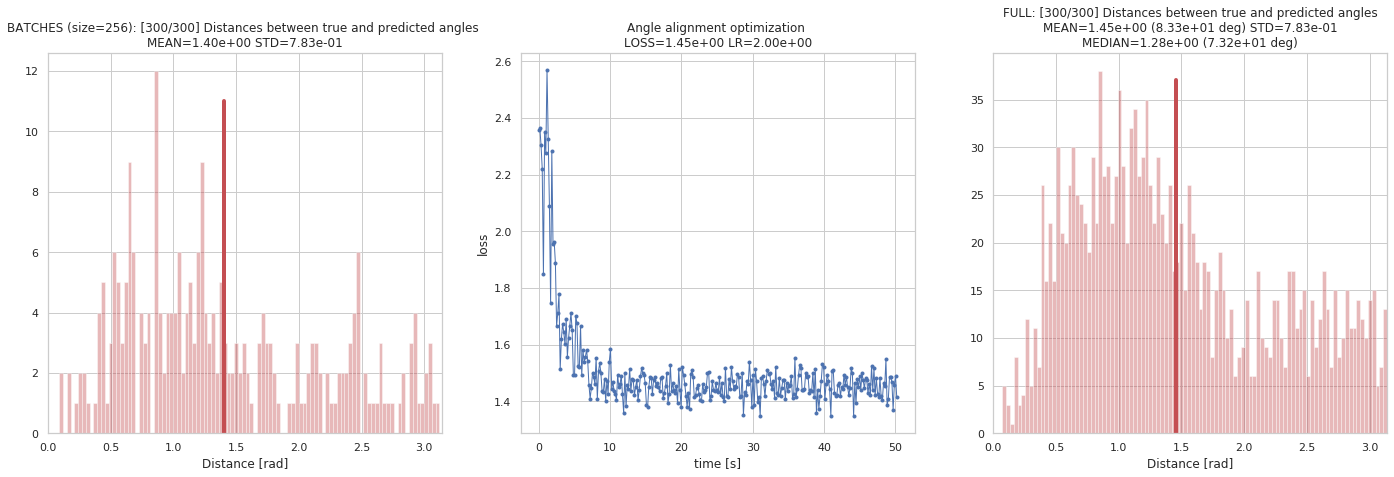

step 30/300 (5s): loss = 1.92e+00
step 60/300 (10s): loss = 1.51e+00
step 90/300 (15s): loss = 1.46e+00
step 120/300 (22s): loss = 1.45e+00
step 150/300 (26s): loss = 1.45e+00
step 180/300 (32s): loss = 1.45e+00
step 210/300 (36s): loss = 1.45e+00
step 240/300 (41s): loss = 1.46e+00
step 270/300 (46s): loss = 1.45e+00
step 300/300 (51s): loss = 1.46e+00



In [70]:
if rerun:
    m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                            steps=300, 
                                                            batch_size=256, 
                                                            optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                            angles_true=angles_true[test_idx], 
                                                            angles_predicted=np.array(angles_predicted))
    m = m
    trajectory_first = trajectory[0]
    loss_first = losses[0]
    trajectory_last = trajectory[-1]
    loss_last = losses[-1]
else:
    pass
#     m = [1.0, 1.0, 1.0, -1.0]
#     trajectory_first = [1.55300104, 2.81036984, 5.2178074 , 0.18295697, 2.11496371, 3.09141405]
#     loss_first = 2.661634550544549
#     trajectory_last = [ 8.34225157, 20.60956391, 19.13156328, 11.4381577 ,  2.8817712 , 16.02597525]
#     loss_last = 0.418361192772094

In [71]:
m, trajectory_first, loss_first, trajectory_last, loss_last

([1.0, 1.0, 1.0, -1.0],
 array([5.65242174, 0.0224704 , 0.83651675, 4.1511786 , 1.37320311,
        1.17739374]),
 2.3566812748149943,
 array([  1.50937436, -22.21026416,  37.58774083,  -9.54505163,
         28.55895761, -12.95182631]),
 1.415914373979307)

Text(0.77, 0.72, '$E$ = 2.3567 rad')

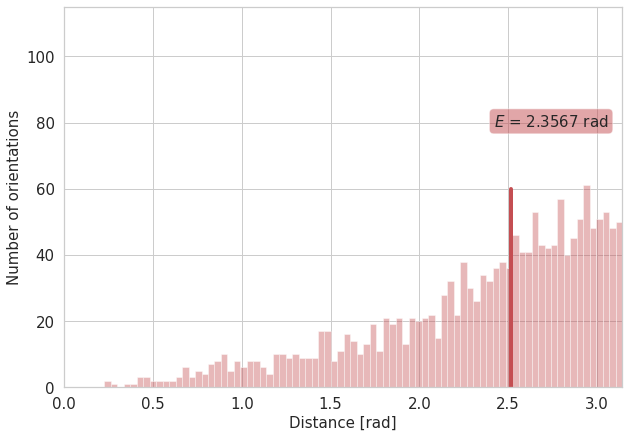

In [72]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
q_predicted_rot = update_quaternion(m, [tf.Variable(trajectory_first)], q_predicted)
d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 115)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=80, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.77, 0.72, f"$E$ = {loss_first:.4f} rad", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

Text(0.03, 0.95, '$E$ = 1.4159 rad')

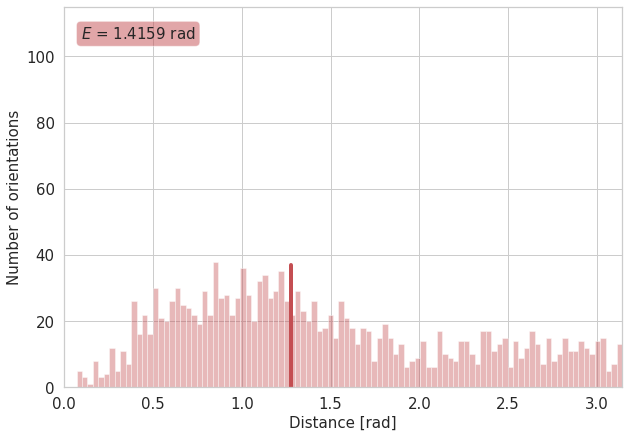

In [73]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
q_predicted_rot = update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted)
d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 115)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=100, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.03, 0.95, f"$E$ = {loss_last:.4f} rad", transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)

---

# Var 25

In [42]:
#data = np.load("/mnt/scratch/students/angle_recovery_limited3.14_estimated_noisy25.npz")
data = np.load("/mnt/scratch/students/angle_recovery_noisy25_limited3.14_estimated_50k.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)

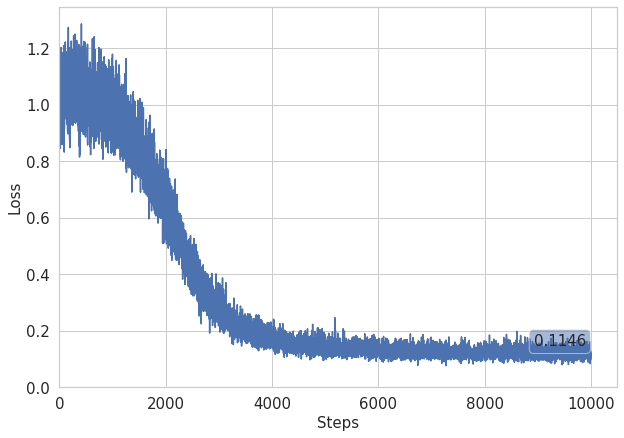

In [43]:
losses_plot = losses[:10000]

fig, ax = plt.subplots(figsize=(10,7))
plt.plot(losses_plot) # np.arange(0., 0.474*len(losses[losses>1e-5]), 0.474),
plt.xlabel("Steps", fontsize=tick_size)
plt.ylabel("Loss", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_xlim(0)
ax.set_ylim(0)

props = dict(boxstyle='round', facecolor='b', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.85, 0.14, f"{np.mean(losses_plot[-10:]):.4f}", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

plt.show()

In [45]:
rerun=False

In [46]:
if rerun:
    m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                            steps=300, 
                                                            batch_size=256, 
                                                            optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                            angles_true=angles_true[test_idx], 
                                                            angles_predicted=np.array(angles_predicted))
    m = m
    trajectory_first = trajectory[0]
    loss_first = losses[0]
    trajectory_last = trajectory[-1]
    loss_last = losses[-1]
else:
    m = [1.0, 1.0, 1.0, 1.0],
    trajectory_first = [0.03615388, 3.11827248, 0.73511663, 0.29532848, 5.80216281, 2.68150876]
    loss_first = 2.1285836265718885
    trajectory_last = [ -0.57854348, -12.2470545 , -12.66416106,   2.67347188, 3.78332438, -10.92041151]
    loss_last = 0.7251250169031774
#     m = [1.0, 1.0, 1.0, -1.0]
#     trajectory_first = [1.55300104, 2.81036984, 5.2178074 , 0.18295697, 2.11496371, 3.09141405]
#     loss_first = 2.661634550544549
#     trajectory_last = [ 8.34225157, 20.60956391, 19.13156328, 11.4381577 ,  2.8817712 , 16.02597525]
#     loss_last = 0.418361192772094

In [47]:
m, trajectory_first, loss_first, trajectory_last, loss_last

(([1.0, 1.0, 1.0, 1.0],),
 [0.03615388, 3.11827248, 0.73511663, 0.29532848, 5.80216281, 2.68150876],
 2.1285836265718885,
 [-0.57854348,
  -12.2470545,
  -12.66416106,
  2.67347188,
  3.78332438,
  -10.92041151],
 0.7251250169031774)

Text(0.77, 0.72, '$E$ = 2.1286 rad')

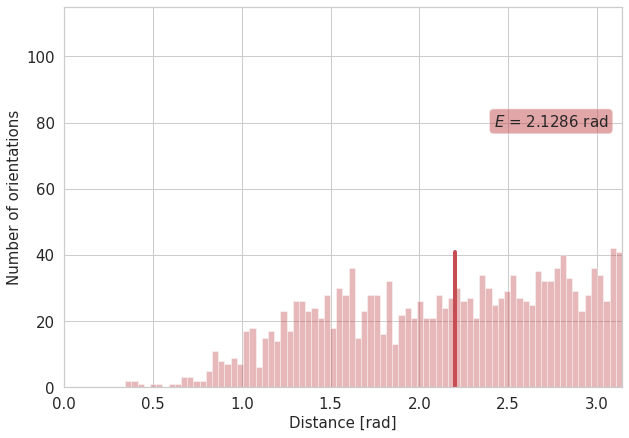

In [50]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
q_predicted_rot = np.squeeze(update_quaternion(m, [tf.Variable(trajectory_first)], q_predicted[test_idx]))
d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 115)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=80, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.77, 0.72, f"$E$ = {loss_first:.4f} rad", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

Text(0.03, 0.95, '$E$ = 0.7251 rad')

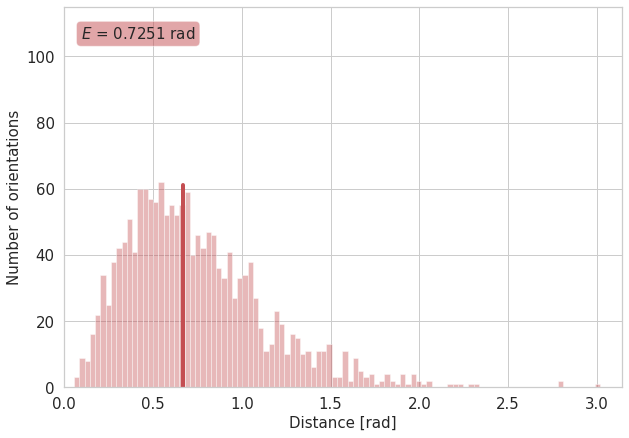

In [52]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
q_predicted_rot = np.squeeze(update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted[test_idx]))
d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 115)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=100, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.03, 0.95, f"$E$ = {loss_last:.4f} rad", transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)

---

# Just test status

In [181]:
#data = np.load("/mnt/scratch/students/angle_recovery_limited3.14_estimated_noisy20.npz")
TRANSLATION = 20
data = np.load(f"/mnt/scratch/students/angle_recovery_translation{TRANSLATION}_limited3.14_estimated_50k.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)

/home/jbanjac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


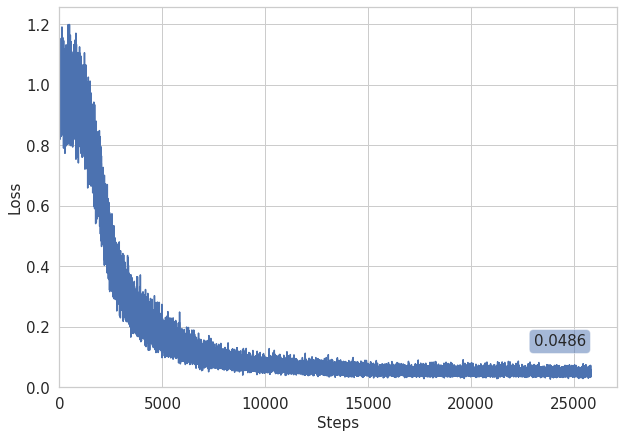

In [182]:
losses_plot = losses[losses>1e-6]

fig, ax = plt.subplots(figsize=(10,7))
plt.plot(losses_plot) # np.arange(0., 0.474*len(losses[losses>1e-5]), 0.474),
plt.xlabel("Steps", fontsize=tick_size)
plt.ylabel("Loss", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_xlim(0)
ax.set_ylim(0)

props = dict(boxstyle='round', facecolor='b', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.85, 0.14, f"{np.mean(losses_plot[-10:]):.4f}", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

plt.show()

# Just test status

In [175]:
#data = np.load("/mnt/scratch/students/angle_recovery_limited3.14_estimated_noisy20.npz")
NOISY_VAR = 20
data = np.load(f"/mnt/scratch/students/angle_recovery_noisy{NOISY_VAR}_limited3.14_estimated_50k.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)

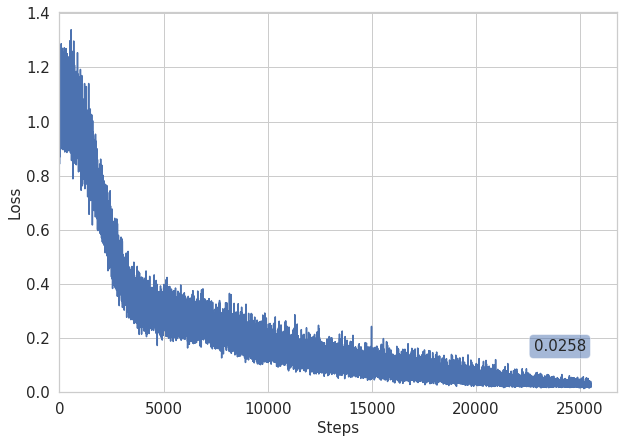

In [176]:
losses_plot = losses[losses>1e-6]

fig, ax = plt.subplots(figsize=(10,7))
plt.plot(losses_plot) # np.arange(0., 0.474*len(losses[losses>1e-5]), 0.474),
plt.xlabel("Steps", fontsize=tick_size)
plt.ylabel("Loss", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_xlim(0)
ax.set_ylim(0)

props = dict(boxstyle='round', facecolor='b', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.85, 0.14, f"{np.mean(losses_plot[-10:]):.4f}", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

plt.show()